In [45]:
import os
import sys
import random
import time
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd

import requests

import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis import predict_pb2
import tensorflow as tf

SERVER = '192.168.9.23'
# SERVER = 'cn.verniy.org'
print('TF Serving server:', SERVER)

MRCNN_DIR = os.path.abspath("../")
sys.path.append(MRCNN_DIR)
print(MRCNN_DIR)

COCO_DIR = os.path.abspath(MRCNN_DIR + '/samples')
sys.path.append(COCO_DIR)
print(COCO_DIR)

UTILS_DIR = os.path.abspath(MRCNN_DIR + '/utils')
sys.path.append(UTILS_DIR)
print(UTILS_DIR)

# IMG_PATH = os.path.abspath(MRCNN_DIR + "/just4fun")
IMG_PATH = os.path.abspath(MRCNN_DIR + "/just4fun/best01.jpg")
# TODO: 文件夹批量处理
if os.path.isdir(IMG_PATH):
    BATCH_NUM = len([f for f in os.listdir(IMG_PATH) if not f.startswith('.')])
else:
    BATCH_NUM = 1
print(IMG_PATH)


TF Serving server: 192.168.9.23
/home/verniy/Projects/Mask_RCNN
/home/verniy/Projects/Mask_RCNN/samples
/home/verniy/Projects/Mask_RCNN/utils
/home/verniy/Projects/Mask_RCNN/just4fun/best01.jpg


### Configs

In [46]:
from mrcnn import visualize
from coco.coco import CocoConfig

from utils.transform import ImageTransform
from utils.preprocess import PreprocessImage
from utils.postprocess import PostprocessImage

# Step 1
# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Step 2
def get_config():
    class InferenceConfig(CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = BATCH_NUM

    config = InferenceConfig()
    return config

# Step 3
config = get_config()
transformClass = ImageTransform(config)
preprocessClass = PreprocessImage(config)
postprocessClass = PostprocessImage(config)

# Debug
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Prepare Image

uint8
float64


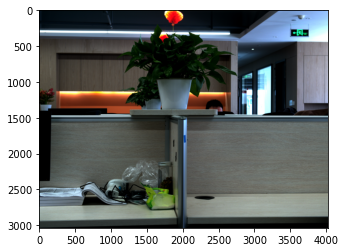

In [47]:
if os.path.isfile(IMG_PATH):
    image = skimage.io.imread(IMG_PATH)
    # image = transformClass.transform(image, pad_width = 200)
    plt.imshow(image)
    print(image.dtype)
else:
    image = []
    for i in [f for f in os.listdir(IMG_PATH) if not f.startswith('.')]:
        image_i = skimage.io.imread(IMG_PATH + '/'+ i)
        print(i)
        image.append(image_i)
        # image = transformClass.transform(image, pad_width = 200)
        plt.imshow(image_i)
        print(image_i.dtype)
molded_image, image_meta, anchors, window = preprocessClass.preprocess_input(image)
print(molded_image.dtype)

### TF-SERVING REST Call

REST status code: 200


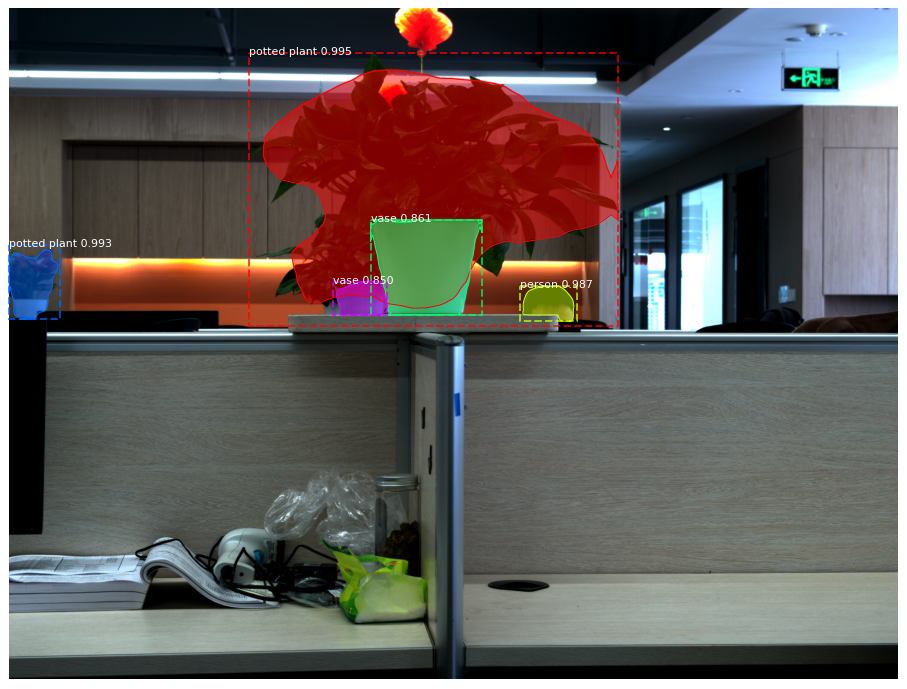

In [4]:
# Step 1
rest_payload = {
            "signature_name": "serving_default",
            "instances": [
                {
                    'input_anchors': anchors.tolist(),
                    'input_image': molded_image.tolist(),
                    'input_image_meta': image_meta.tolist()
                }]
            }
headers = {"content-type": "application/json"}
rest_json_response = requests.post('http://' + SERVER + ':8501/v1/models/mrcnn_coco:predict',
                              data = json.dumps(rest_payload),
                              headers = headers)

# Step2
print('REST status code:', rest_json_response.status_code)

# Step3
rest_result = rest_json_response.json()
rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])
rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)

visualize.display_instances(
    image,
    rest_rois,
    rest_masks,
    rest_class_ids,
    class_names,
    rest_scores
)

In [ ]:
# Time benchmark
time_start = time.time()
repeat = 10
for i in range(repeat):
    rest_payload = {
                "signature_name": "serving_default",
                "instances": [
                    {
                        'input_anchors': anchors.tolist(),
                        'input_image': molded_image.tolist(),
                        'input_image_meta': image_meta.tolist()
                    }]
                }
    headers = {"content-type": "application/json"}
    rest_json_response = requests.post('http://' + SERVER + ':8501/v1/models/mrcnn_coco:predict',
                                  data = json.dumps(rest_payload),
                                  headers = headers)
        
    rest_result = rest_json_response.json()
    rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
    rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])  

    rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)
    

time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

### TF-SERVING GRPC Call

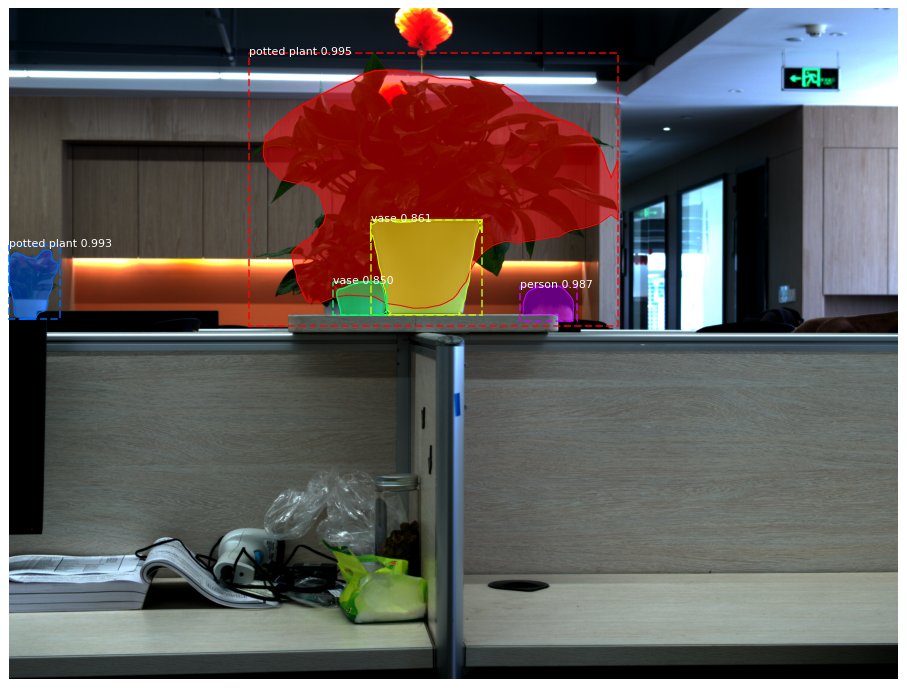

[1.71899706e-01 2.69151568e-01 4.78987008e-01 6.84724689e-01
 5.90000000e+01 9.95486677e-01 3.87325734e-01 0.00000000e+00
 4.71163988e-01 5.62871471e-02 5.90000000e+01 9.92929041e-01
 4.34134811e-01 5.74705720e-01 4.73295420e-01 6.39271200e-01
 1.00000000e+00 9.86732662e-01 3.59609127e-01 4.06743199e-01
 4.65821296e-01 5.31930864e-01 7.60000000e+01 8.61356318e-01
 4.28938031e-01 3.64350975e-01 4.66581434e-01 4.24606979e-01
 7.60000000e+01 8.49813521e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [48]:
# Step 1
channel = grpc.insecure_channel(SERVER + ':8500', options=[('grpc.max_receive_message_length', 4096 * 4096 * 3)])

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'mrcnn_coco'
request.model_spec.signature_name = 'serving_default'
np.expand_dims(image, axis=0)

request.inputs['input_image'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
request.inputs['input_image_meta'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
request.inputs['input_anchors'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

grpc_result = stub.Predict(request)

# Step 2
grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)
grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)

# Step 3
visualize.display_instances(
    image,
    grpc_rois,
    grpc_masks,
    grpc_class_ids,
    class_names,
    grpc_scores
)

In [13]:
# Time benchmark
time_start = time.time()
repeat = 10
for i in range(repeat):
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'mrcnn_coco'
    request.model_spec.signature_name = 'serving_default'
    np.expand_dims(image, axis=0)

    request.inputs['input_image'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
    request.inputs['input_image_meta'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
    request.inputs['input_anchors'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

    grpc_result = stub.Predict(request)
    
    grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
    grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)

    grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)
    
time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

Total elapsed time: 37.717042446136475 seconds
Average latency per batch: 3.7717042446136473 seconds
